<a href="https://colab.research.google.com/github/jihun0423/electric_predict/blob/main/electric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('./gdrive/MyDrive/electric')

## 전력 데이터 전처리

In [132]:
import pandas as pd
df = pd.read_csv('train.csv')

In [133]:
df.head(5)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [134]:
df['날짜']=df['일시'].str.split(' ').str[0]
df['hour']=df['일시'].str.split(' ').str[1].astype('int')

In [135]:
df['날짜'] = pd.to_datetime(df.날짜)

In [136]:
df.head(5)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),날짜,hour
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,2022-06-01,0
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,2022-06-01,1
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88,2022-06-01,2
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76,2022-06-01,3
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40,2022-06-01,4


In [137]:
import numpy as np
df['hour'] = np.sin(2*np.pi*df['hour']/24)


In [138]:
df['dow'] = df['날짜'].dt.weekday
df['month'] = df['날짜'].dt.month
df['day'] = df['날짜'].dt.day
df['holiday'] = df['dow'].apply(lambda x: 0 if x<5 else 1)

In [139]:
from datetime import datetime
holiday = [datetime(2022, 6, 1), datetime(2022, 6, 6), datetime(2022, 8, 15)]
df['holiday']=((df['dow']>4) | (df['날짜'].isin(holiday))) *1

In [140]:
# from datetime import datetime
# holiday = [datetime(2022, 6, 1), datetime(2022, 6, 6), datetime(2022, 8, 15)]
# df['holiday'] = df.apply(lambda x: 1 if ((df['날짜'].isin(holiday)) | (df['dow'] > 4)) else 0, axis=1)

### 결측치 처리

In [141]:
df.isnull().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
날짜                    0
hour                  0
dow                   0
month                 0
day                   0
holiday               0
dtype: int64

In [142]:
df['강수량(mm)']=df['강수량(mm)'].fillna(0)

In [143]:
df.groupby(['건물번호','month','hour'],as_index=False).mean()

<ipython-input-143-2a8318cf48cc>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['건물번호','month','hour'],as_index=False).mean()


,건물번호,month,hour,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),dow,day,holiday
0,1,6,-1.000000,25.610000,0.723333,2.906667,65.633333,0.340000,0.651667,2595.296,2.966667,15.5,0.333333
1,1,6,-0.965926,24.886667,1.133333,3.083333,67.433333,0.323333,0.307333,2419.520,2.966667,15.5,0.333333
2,1,6,-0.965926,25.966667,0.493333,2.960000,64.700000,0.286667,0.928000,2838.504,2.966667,15.5,0.333333
3,1,6,-0.866025,23.923333,0.756667,3.026667,70.633333,0.073333,0.061667,2230.592,2.966667,15.5,0.333333
4,1,6,-0.866025,26.123333,0.326667,3.143333,64.700000,0.280000,1.131000,3422.256,2.966667,15.5,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,100,8,0.707107,26.425000,1.208333,1.341667,88.125000,0.195833,NaN,1121.330,2.750000,12.5,0.291667
6596,100,8,0.866025,24.762500,0.979167,1.029167,95.833333,NaN,NaN,406.050,2.750000,12.5,0.291667
6597,100,8,0.866025,25.570833,2.050000,1.170833,92.250000,0.120833,NaN,980.010,2.750000,12.5,0.291667
6598,100,8,0.965926,24.864583,1.177083,1.014583,95.750000,0.029167,NaN,646.080,2.750000,12.5,0.291667


In [144]:
df_nummonthhour_mean = df.groupby(['건물번호','month','hour'],as_index=False).mean()

<ipython-input-144-dd149735d4ae>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_nummonthhour_mean = df.groupby(['건물번호','month','hour'],as_index=False).mean()


In [145]:
null_feature = ['풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)']

In [146]:
for col in null_feature:
  for i in df[df[col].isnull()].index:
    num = df.loc[i,'건물번호']
    month = df.loc[i,'month']
    hour = df.loc[i,'hour']
    data_mean = df_nummonthhour_mean[(df_nummonthhour_mean['건물번호']==num)&(df_nummonthhour_mean['month']==month)&(df_nummonthhour_mean['hour']==hour)]
    df.loc[i,col] = data_mean[col].values

In [147]:
df['일조(hr)'] = df['일조(hr)'].fillna(0)

In [148]:
df['일사(MJ/m2)'] = df['일사(MJ/m2)'].fillna(0)

In [149]:
df.isnull().sum()

num_date_time    0
건물번호             0
일시               0
기온(C)            0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
일조(hr)           0
일사(MJ/m2)        0
전력소비량(kWh)       0
날짜               0
hour             0
dow              0
month            0
day              0
holiday          0
dtype: int64

### feature 생성

In [150]:
df['THI'] = 9/5*df['기온(C)'] - 0.55*(1-df['습도(%)']/100)*(9/5*df['습도(%)']-26)+32
df['THI'] = pd.cut(df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
df['THI'] = df['THI'].astype(int)

In [151]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

In [152]:
cdhs = np.array([])
for num in range(1,101,1):
    temp = df[df['건물번호'] == num]
    cdh = CDH(temp['기온(C)'].values)
    cdhs = np.concatenate([cdhs, cdh])
df['CDH'] = cdhs

In [153]:
df

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),날짜,hour,dow,month,day,holiday,THI,CDH
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,0.00,0.000000,1085.28,2022-06-01,0.000000,2,6,1,1,1,-7.4
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,0.00,0.000000,1047.36,2022-06-01,0.258819,2,6,1,1,1,-15.4
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,0.42,1.396667,974.88,2022-06-01,0.500000,2,6,1,1,1,-23.7
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,0.00,0.000000,953.76,2022-06-01,0.707107,2,6,1,1,1,-33.0
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,0.00,0.000000,986.40,2022-06-01,0.866025,2,6,1,1,1,-40.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,0.0,0.9,86.0,0.50,0.000000,881.04,2022-08-24,-0.965926,2,8,24,0,1,-19.6
203996,100_20220824 20,100,20220824 20,22.4,0.0,1.3,86.0,0.00,0.000000,798.96,2022-08-24,-0.866025,2,8,24,0,1,-20.2
203997,100_20220824 21,100,20220824 21,21.3,0.0,1.0,92.0,0.00,0.000000,825.12,2022-08-24,-0.707107,2,8,24,0,1,-22.3
203998,100_20220824 22,100,20220824 22,21.0,0.0,0.3,94.0,0.00,0.000000,640.08,2022-08-24,-0.500000,2,8,24,0,1,-25.1


In [154]:
df['dow'] = df['dow'].astype('str')

In [155]:
df_numdowhour_mean = df.groupby(['건물번호','dow','hour'],as_index=False).mean()

<ipython-input-155-f60f7948a67e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_numdowhour_mean = df.groupby(['건물번호','dow','hour'],as_index=False).mean()


In [156]:
df.groupby(['건물번호','dow','hour'],as_index=False).mean()[['건물번호','dow','hour','전력소비량(kWh)']]

<ipython-input-156-3d2d759e2eeb>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['건물번호','dow','hour'],as_index=False).mean()[['건물번호','dow','hour','전력소비량(kWh)']]


,건물번호,dow,hour,전력소비량(kWh)
0,1,0,-1.000000,2855.94
1,1,0,-0.965926,2658.10
2,1,0,-0.965926,3507.32
3,1,0,-0.866025,2409.60
4,1,0,-0.866025,4018.90
...,...,...,...,...
15395,100,6,0.707107,1067.24
15396,100,6,0.866025,377.84
15397,100,6,0.866025,936.68
15398,100,6,0.965926,606.76


In [157]:
df_numdowhour_mean.columns.values[3] = 'kWh_ndh_mean'

In [158]:
df_numdowhour_mean

,건물번호,dow,hour,kWh_ndh_mean,강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),month,day,holiday,THI,CDH
0,1,0,-1.000000,28.025000,2.308333,3.333333,70.333333,0.350000,0.647500,2855.94,7.000000,14.166667,0.166667,1.583333,15.558333
1,1,0,-0.965926,27.508333,1.100000,3.275000,72.333333,0.308333,0.319167,2658.10,7.000000,14.166667,0.166667,1.666667,18.800000
2,1,0,-0.965926,28.316667,0.658333,3.441667,69.833333,0.333333,0.994167,3507.32,7.000000,14.166667,0.166667,1.666667,11.666667
3,1,0,-0.866025,26.841667,0.008333,3.075000,74.083333,0.075000,0.059167,2409.60,7.000000,14.166667,0.166667,1.583333,20.841667
4,1,0,-0.866025,28.508333,0.883333,2.950000,70.333333,0.291667,1.151667,4018.90,7.000000,14.166667,0.166667,1.666667,7.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15395,100,6,0.707107,25.275000,0.025000,1.391667,83.750000,0.250000,0.000000,1067.24,6.916667,15.750000,1.000000,1.666667,-28.083333
15396,100,6,0.866025,23.008333,0.275000,0.533333,93.750000,0.000000,0.000000,377.84,6.916667,15.750000,1.000000,1.916667,-9.725000
15397,100,6,0.866025,24.258333,0.158333,0.941667,88.666667,0.158333,0.000000,936.68,6.916667,15.750000,1.000000,1.666667,-28.308333
15398,100,6,0.965926,23.058333,0.333333,0.537500,93.291667,0.102237,0.000000,606.76,6.916667,15.750000,1.000000,1.791667,-21.333333


In [159]:
df_numdowhour_mean = df.groupby(['건물번호','dow','hour'],as_index=False).mean()[['건물번호','dow','hour','전력소비량(kWh)']]
df_numdowhour_mean.columns.values[3] = 'kWh_ndh_mean'
df_numdowhour_sd = df.groupby(['건물번호','dow','hour'],as_index=False).std()[['건물번호','dow','hour','전력소비량(kWh)']]
df_numdowhour_sd.columns.values[3] = 'kWh_ndh_std'
df_numdow_mean = df.groupby(['건물번호','dow'],as_index=False).mean()[['건물번호','dow','전력소비량(kWh)']]
df_numdow_mean.columns.values[2] = 'kWh_nh_mean'
df_numdow_sd = df.groupby(['건물번호','dow'],as_index=False).std()[['건물번호','dow','전력소비량(kWh)']]
df_numdow_sd.columns.values[2] = 'kWh_nh_sd'

<ipython-input-159-725d28db509e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_numdowhour_mean = df.groupby(['건물번호','dow','hour'],as_index=False).mean()[['건물번호','dow','hour','전력소비량(kWh)']]
<ipython-input-159-725d28db509e>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_numdow_mean = df.groupby(['건물번호','dow'],as_index=False).mean()[['건물번호','dow','전력소비량(kWh)']]
<ipython-input-159-725d28db509e>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou

In [160]:
df=df.merge(df_numdowhour_mean,on=['건물번호','dow','hour'],how='left')
df=df.merge(df_numdowhour_sd,on=['건물번호','dow','hour'],how='left')
df=df.merge(df_numdow_mean,on=['건물번호','dow'],how='left')
df=df.merge(df_numdow_sd,on=['건물번호','dow'],how='left')

In [161]:
df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),...,dow,month,day,holiday,THI,CDH,kWh_ndh_mean,kWh_ndh_std,kWh_nh_mean,kWh_nh_sd
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,0.00,0.000000,1085.28,...,2,6,1,1,1,-7.4,1774.744615,517.982222,2682.796923,1136.240307
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,0.00,0.000000,1047.36,...,2,6,1,1,1,-15.4,1687.347692,500.769931,2682.796923,1136.240307
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,0.42,1.396667,974.88,...,2,6,1,1,1,-23.7,2721.175385,1279.562737,2682.796923,1136.240307
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,0.00,0.000000,953.76,...,2,6,1,1,1,-33.0,1522.153846,436.601091,2682.796923,1136.240307
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,0.00,0.000000,986.40,...,2,6,1,1,1,-40.6,1506.793846,405.518091,2682.796923,1136.240307


## 건물 정보 전처리

In [162]:
df_b = pd.read_csv('building_info.csv')

In [163]:
df_b.head(5)

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [164]:
df_b.isnull().sum()

건물번호            0
건물유형            0
연면적(m2)         0
냉방면적(m2)        0
태양광용량(kW)       0
ESS저장용량(kWh)    0
PCS용량(kW)       0
dtype: int64

In [165]:
df_b=df_b.replace('-',0)

In [166]:
df_b.groupby('건물유형',as_index=False).mean()

<ipython-input-166-127e8baf7384>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_b.groupby('건물유형',as_index=False).mean()


,건물유형,건물번호,연면적(m2),냉방면적(m2)
0,건물기타,8.0,1.084411e+05,5.417702e+04
1,공공,19.5,1.687602e+06,1.411875e+06
2,대학교,27.5,3.699181e+05,2.478968e+05
3,데이터센터,34.0,1.851530e+04,1.187450e+04
4,백화점및아울렛,40.5,1.036846e+05,5.771201e+04
5,병원,48.5,1.019759e+05,8.230490e+04
6,상용,56.5,9.267848e+04,6.076371e+04
7,아파트,64.5,2.615197e+05,1.418271e+05
8,연구소,72.5,1.118182e+05,7.612745e+04
9,지식산업센터,80.5,1.735248e+05,7.056204e+04


In [167]:
conv_dict = dict(zip(list(df_b['건물유형'].unique()), [0,1,2,3,4,5,6,7,8,9,10,11]))
conv_dict

{'건물기타': 0,
 '공공': 1,
 '대학교': 2,
 '데이터센터': 3,
 '백화점및아울렛': 4,
 '병원': 5,
 '상용': 6,
 '아파트': 7,
 '연구소': 8,
 '지식산업센터': 9,
 '할인마트': 10,
 '호텔및리조트': 11}

In [168]:
df_b['건물유형'] = df_b['건물유형'].map(conv_dict)

In [169]:
df = df.merge(df_b,on = '건물번호',how='left')

In [170]:
df.head(5)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),...,kWh_ndh_mean,kWh_ndh_std,kWh_nh_mean,kWh_nh_sd,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,0.00,0.000000,1085.28,...,1774.744615,517.982222,2682.796923,1136.240307,0,110634.0,39570.0,0,0,0
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,0.00,0.000000,1047.36,...,1687.347692,500.769931,2682.796923,1136.240307,0,110634.0,39570.0,0,0,0
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,0.42,1.396667,974.88,...,2721.175385,1279.562737,2682.796923,1136.240307,0,110634.0,39570.0,0,0,0
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,0.00,0.000000,953.76,...,1522.153846,436.601091,2682.796923,1136.240307,0,110634.0,39570.0,0,0,0
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,0.00,0.000000,986.40,...,1506.793846,405.518091,2682.796923,1136.240307,0,110634.0,39570.0,0,0,0


In [191]:
df['dow'] = df['dow'].astype('int32')
df['태양광용량(kW)'] = df['태양광용량(kW)'].astype('float')
df['ESS저장용량(kWh)'] = df['ESS저장용량(kWh)'].astype('float')
df['PCS용량(kW)'] = df['PCS용량(kW)'].astype('float')

In [185]:
df=df.drop(columns=['날짜'])

In [192]:
df.to_pickle('electric.pickle')

In [187]:
df.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', 'hour', 'dow', 'month', 'day',
       'holiday', 'THI', 'CDH', 'kWh_ndh_mean', 'kWh_ndh_std', 'kWh_nh_mean',
       'kWh_nh_sd', '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)',
       'PCS용량(kW)'],
      dtype='object')

In [176]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 10.9 MB/s eta 0:00:00


In [189]:
x

,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),hour,dow,month,day,...,kWh_ndh_mean,kWh_ndh_std,kWh_nh_mean,kWh_nh_sd,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
12240,17.9,0.0,1.0,48.0,0.000000,0.000000,0.000000,2,6,1,...,440.640000,127.591473,811.897692,282.419976,0,101711.52,41341.1,0,800,300
12241,17.7,0.0,1.2,50.0,0.000000,0.000000,0.258819,2,6,1,...,442.744615,122.878092,811.897692,282.419976,0,101711.52,41341.1,0,800,300
12242,17.5,0.0,1.7,49.0,0.473333,1.425667,0.500000,2,6,1,...,771.655385,364.521963,811.897692,282.419976,0,101711.52,41341.1,0,800,300
12243,15.9,0.0,0.4,54.0,0.000000,0.000000,0.707107,2,6,1,...,426.793846,120.198970,811.897692,282.419976,0,101711.52,41341.1,0,800,300
12244,16.6,0.0,2.6,53.0,0.000000,0.000000,0.866025,2,6,1,...,428.252308,116.872917,811.897692,282.419976,0,101711.52,41341.1,0,800,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14275,25.9,0.0,2.3,63.0,0.000000,0.040000,-0.965926,2,8,24,...,954.443077,95.363683,811.897692,282.419976,0,101711.52,41341.1,0,800,300
14276,24.8,0.0,2.7,66.0,0.000000,0.000000,-0.866025,2,8,24,...,931.716923,104.597783,811.897692,282.419976,0,101711.52,41341.1,0,800,300
14277,23.9,0.0,1.9,70.0,0.000000,0.000000,-0.707107,2,8,24,...,686.547692,162.600149,811.897692,282.419976,0,101711.52,41341.1,0,800,300
14278,23.6,0.0,0.7,71.0,0.000000,0.000000,-0.500000,2,8,24,...,539.353846,149.630405,811.897692,282.419976,0,101711.52,41341.1,0,800,300


train data shape
x:(1872, 23), y:(1872,)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


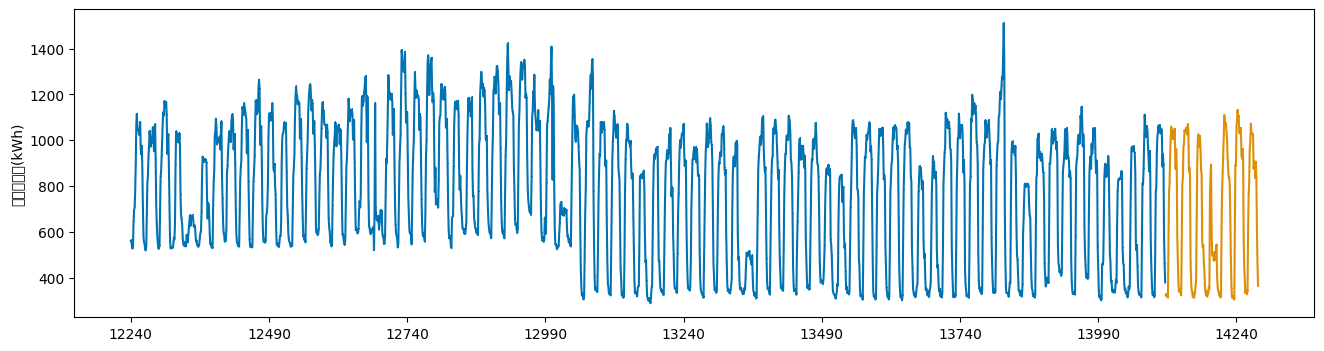

In [197]:
## 7번 건물의 발전량

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import seaborn as sns


y = df.loc[df.건물번호 == 7, '전력소비량(kWh)']
x = df.loc[df.건물번호 == 7, ].iloc[:, 3:].drop(columns=['전력소비량(kWh)'])

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [179]:
!pip install xgboost

In [181]:
from xgboost import XGBRegressor

In [198]:
xgb = XGBRegressor()
xgb.fit(x_train,y_train)
y_pred = xgb.predict(x_valid)

In [199]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [200]:
SMAPE(y_valid,y_pred)

4.476917445001494

In [ ]:
from sklearn.metrics import

In [ ]:
pip install -U pandasql

In [ ]:
from pandasql import sqldf

query = """select 풍속(m/s) from df group by 건물번호, month, 시간 """

df1 = sqldf(query)
